Our task now is to use a neural network $f_{\theta}$ to approximate the simulator $\mathcal{P}$ created with the Runge-Kutta (RK4) method. The properties and functionality of the simulator can be found in the `lorenz63.py` file. We will use a Multilayer Perceptron (MLP) neural network. The main task is to learn the parameter(s) $\theta$ that approxiates $\mathcal{P}$: $$f_{\theta} \approx  \mathcal{P}$$ The idea is to try to emulate/approximate the Runge-Kutta scheme using a neural network. In RK4, we used previous states to explicitly compute the next state. Now, blind to the scheme, we will try to learn the parameters $\theta$ of our neural network from the trajectory by having the NN predict the next state given the current state and learned parameters. I will try both cases: with and without noise in the Lorenz simulator. 

For practitioners, what I am trying to do is learning the discrete flow map using an MLP based emulator. Lorenz '63 is a first order autonomous ODE (no mention of time in the equations).

In [65]:
# import libraries 
import jax
import jax.numpy as jnp
import jax.nn
import matplotlib.pyplot as plt
import jax.tree_util as jtu

# deep learning framework, we'll use their MLP architechtrue 
import equinox as eqx

# gradient processing library, for adam optimizer 
import optax

# training monitoring 
from tqdm import tqdm

# generate data
from Study.lorenz63JAX import rollout, LorenzSimulatorK4


In [66]:
u_0_set = jax.random.normal(jax.random.PRNGKey(0), (9, 3))
lorenzStepper = LorenzSimulatorK4()
iterations = 7000

rollout_func = rollout(lorenzStepper, iterations, include_init=False)
dataset = jax.vmap(rollout_func)(u_0_set)

There needs to be a more robust way to check this but the initial phase of the trajectory is quite turbulent according to my experience, susceptible to initial conditions. So we will let go off the first 2000 datapoints. 

In [67]:
dataset = jax.vmap(rollout_func)(u_0_set)[:, 2000:]

# divide up into training and testing (we use the first 6 trajectories for training and leave the remaining for testing)
training_set, testing_set = dataset[:6], dataset[6:]

$$\renewcommand{\cP}{\mathcal{P}}$$

### Online learning

Recall how the simulator/stepper works $\cP(u_n) = u_{n+1}$. Our emulator is also a stepper function. $$f_{\theta}(u_n) = \hat{u_n}$$ Because of our dataset above, we already have $$\text{Dataset}: \{ u_0, \cP(u_0),\cdots, \cP(u_{n-1})\}$$ Our MLP based emulator will first make a prediction on $u_0$ and get $f_\theta(u_0) = \hat{u_1}$. Next, it will compute the error $$ e = ||\hat{u_1} -   \cP(u_0)||^2/n = ||\hat{u_1} -  u_1||^2/n$$ Once we have the error, we can gradient descent $\theta$ to minimize the error. Once that is done we have a new theta $$\theta \text{ gradient descent} \to \hat{\theta}$$ Now that we have a theta (which is hopefully better) we can do prediction on $u_1$ and get $f_\theta(u_1) = \hat{u_2}$ and do the whole thing again. Now note that this is technically a time series so we have a create a moving window that takes an input $u_n$ to $f_{\theta}$ given the current best parameter $\theta$ and check the prediction $f_{theta}(u_n) = \hat{u_{n+1}}$ against $u_{n+1}$. So each window must have two data points from our training set $(u_n, u_{n+1})$ 
A few things I will need to keep in mind:
- Normalization: scaling with mean 0, variance 1
- Batching: instead of doing the process like data is arriving one at a time, for the sake of time, we can batch the whole thing and run one gradient step. 
- A residual network that learns the change: $$u_{n+1} = u_n + \Delta t \cdot f_\theta(u_n)$$
- In a chaotic system like Lorenz, if a model is trained to minimize MSE, it will predict the average of all possible outcomes. While this works for predicting general events, for predicting extreme events, this is not physically realistic. 


In [68]:
# create window slices of of size 2

def window_slice_two(single_traj):
    # takes one trajectory of inputs
    # use vmap later to parallelize 
    # counts the number of time steps
    time_step_count = single_traj.shape[0]
    windows = []
    for t in range(time_step_count-1):
        windows.append(single_traj[t:t+2])
    return jnp.stack(windows)

In [69]:
# normalize training data
means = jnp.mean(training_set, axis = (0, 1))
stds = jnp.std(training_set, axis = (0, 1))
training_set_z = (training_set - means)/stds

In [70]:
# do a vmap transformation across all parallel trajectories
training_pairs = jnp.concatenate(jax.vmap(window_slice_two)(training_set_z))

In [71]:
# a dataloader to feed data batches into the training loop
# taken from https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/lorenz_mlp_emulator_jax.ipynb

def dataloader(
    data,
    *,
    batch_size: int,
    key,
):
    """
    Loop generator over the data. The data can be a PyTree or an Array. For
    supervised learning problems you can also hand over a tuple of Arrays
    (=PyTree).
    """

    n_samples_list = [a.shape[0] for a in jtu.tree_leaves(data)]

    if not all(n == n_samples_list[0] for n in n_samples_list):
        raise ValueError(
            "All arrays / PyTree leaves must have the same number of samples. (Leading array axis)"
        )

    n_samples = n_samples_list[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        sub_data = jtu.tree_map(lambda a: a[batch_indices], data)

        yield sub_data

The cost function or loss function we choose next is rather naive and does not take full advantage of the fact that we know quite a few properties of the underlying physical process. Later, we will implement a cost/loss function

$$\mathcal{L} = w_d \mathcal{L}_{\text{data}} + (1-w_d) \mathcal{L}_{\text{physics}}$$
where 
- $\mathcal{L}_{data}$: Standard MSE between the NN prediction and the actual observed next state.
- $\mathcal{L}_{physics}$: This is the "punishment." We will use Automatic Differentiation (in JAX, this is jax.grad or jax.jacobian) to find the derivative of the NN's output with respect to time, and check if it obeys the Lorenz equations: $$\mathcal{L}_{physics} = \text{MSE}\left( \frac{d\hat{u}}{dt} - f(\hat{u}, \sigma, \rho, \beta) \right)$$

[Source](https://doi.org/10.1016/j.jcp.2018.10.045)

In [72]:
# use an MLP to approximate the runge-kutta simulator
lorenz_approx = eqx.nn.MLP(
    in_size = 3,
    out_size = 3,
    width_size = 160,
    depth = 8,
    activation = jax.nn.relu,
    key = jax.random.PRNGKey(42)
)

# adam optimizer
optimizer = optax.adam(optax.warmup_cosine_decay_schedule(0.0, 3e-4, 15_000, 100_000))
opt_state = optimizer.init(eqx.filter(lorenz_approx, eqx.is_array))


In [73]:
def f_true(u, 
        sigma = lorenzStepper.sigma, 
        rho = lorenzStepper.rho, 
        beta = lorenzStepper.beta) -> jnp.ndarray:
    """
    Compute the derivative of the Lorenz system state vector.
    
    Args:
        u: State vector [x, y, z]
        sigma, rho, beta.
    
    Returns:
        Derivative vector [dx/dt, dy/dt, dz/dt]
    """
    x, y, z = u
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    return jnp.array([x_dot, y_dot, z_dot])

In [74]:
dt = lorenzStepper.dt

# we made some new changes compared to @baseline:
# training data is normalized
# loss function is based on residual network
# instead of computing du/dt, we only compute du  

def loss_func(model, data):
    u_0, r_1 = data[:,0], data[:,1]-data[:,0]
    r_1_hat = jax.vmap(model)(u_0) # model's prediction of the residual
    error_data = jnp.mean(jnp.square(r_1_hat - r_1)) # data error

    # 'physics'

    du_dt_true = jax.vmap(f_true)(u_0)
    du_hat  = r_1_hat 
    error_phys = jnp.mean(jnp.square(du_hat - du_dt_true * dt))
    return error_data + 1e-4 * error_phys

# 


In [76]:
@eqx.filter_jit
def updates(model, opt_state, data):
    # calculate loss and gradient 
    loss, grad = eqx.filter_value_and_grad(loss_func)(model, data)
    # update parameters
    updates, opt_state = optimizer.update(grad, opt_state, model)
    model = eqx.apply_updates(model, updates)

    return model, opt_state, loss

shuffle_key = jax.random.PRNGKey(99)
train_loss_history = []

for epoch in tqdm(range(200)):
    shuffle_key, subkey = jax.random.split(shuffle_key)

    for batch in dataloader(training_pairs, batch_size=64, key=subkey):
        lorenz_approx, opt_state, loss = updates(
            lorenz_approx,
            opt_state,
            batch,
        )
        train_loss_history.append(loss)

100%|██████████| 200/200 [03:34<00:00,  1.07s/it]


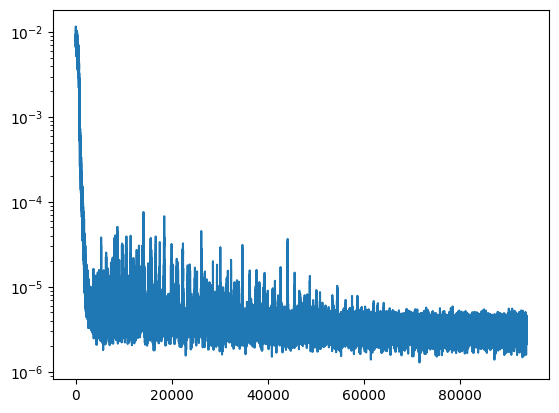

In [77]:
plt.semilogy(train_loss_history)

We must measure the performance of the model against true trajectory. We utilize the testing dataset we isolated to first visually see how our emulator performs. 

In [78]:
# three unseen trajectories with different initial conditions.   
testing_set.shape

(3, 5000, 3)

In [79]:
test_mean = jnp.mean(testing_set, axis = (0,1))
test_std = jnp.std(testing_set, axis = (0,1))
testing_set_z = (testing_set - test_mean)/test_std

In [80]:
# testing 

iterations = 4999
testing_init = testing_set_z[:, 0]

def nn_stepper(u):
    return u + lorenz_approx(u)

rollout_func = rollout(nn_stepper, iterations, include_init=True)
emulated_traj = jax.vmap(rollout_func)(testing_init)

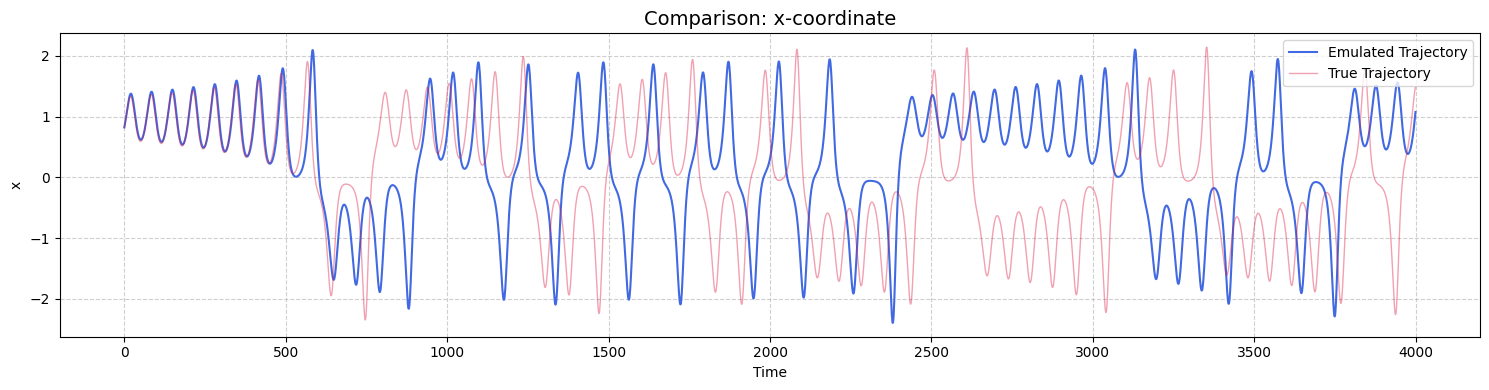

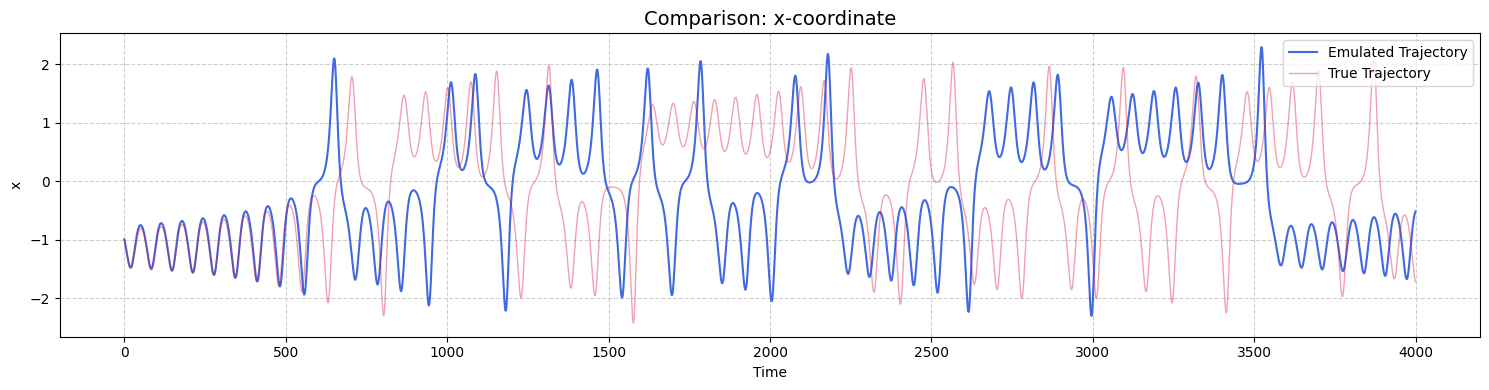

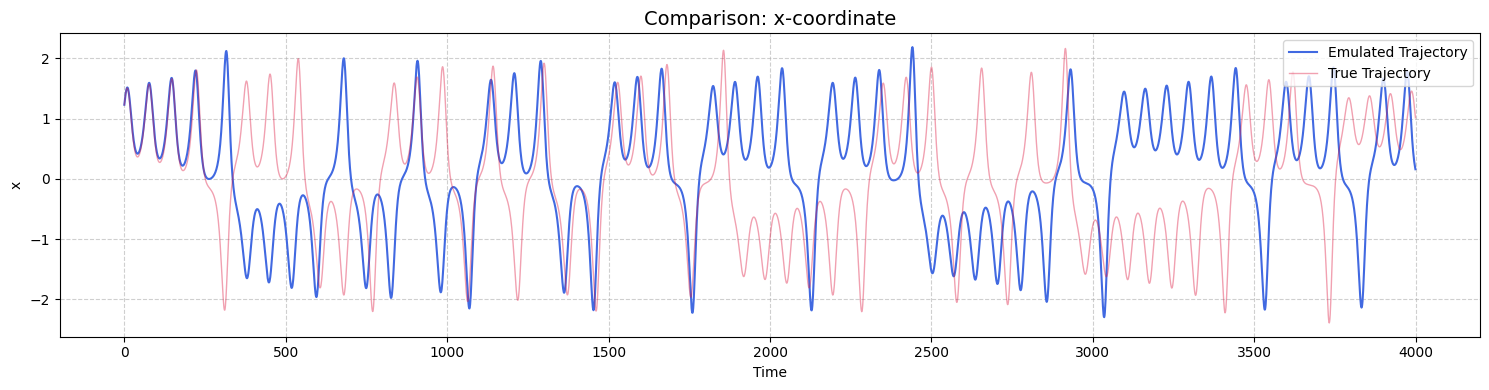

(None, None, None)

In [82]:
def plot_coordinate_comparison(coord_idx, emulated_traj, true_traj):
    """
    Plots a comparison between emulated and true trajectories for a specific coordinate.
    
    Args:
        coord_idx (int): 0 for 'x', 1 for 'y', 2 for 'z'
        emulated_traj: Array of shape (T, 3)
        true_traj: Array of shape (T, 3)
    """
    labels = ["x", "y", "z"]
    colors = ["royalblue", "crimson"] 
    
    # Validation
    if coord_idx not in [0, 1, 2]:
        print("Error: coord_idx must be 0 (x), 1 (y), or 2 (z)")
        return
    UP_UNTIL = 4000
    # time = jnp.arange(len(emulated_traj))
    time = jnp.arange(UP_UNTIL)
    fig, ax = plt.subplots(figsize=(15, 4))
    
    # Plotting
    
    ax.plot(time, emulated_traj[:UP_UNTIL, coord_idx], 
            lw=1.5, color=colors[0], label="Emulated Trajectory")
    
    ax.plot(time, true_traj[:UP_UNTIL, coord_idx], 
            lw=1.0, color=colors[1], alpha=0.4, label="True Trajectory")
    
    # Formatting
    ax.set_title(f"Comparison: {labels[coord_idx]}-coordinate", fontsize=14)
    ax.set_xlabel("Time")
    ax.set_ylabel(f"{labels[coord_idx]}")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()

testing_set = testing_set_z
# 3 different initial conditions 
plot_coordinate_comparison(0, emulated_traj[0], testing_set[0]), plot_coordinate_comparison(0, emulated_traj[1], testing_set[1]), plot_coordinate_comparison(0, emulated_traj[2], testing_set[2])

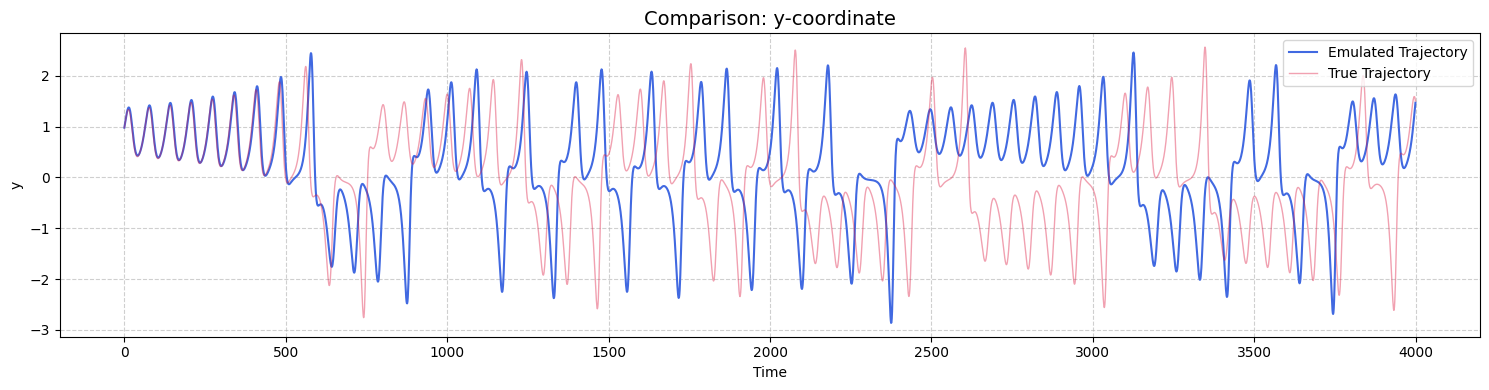

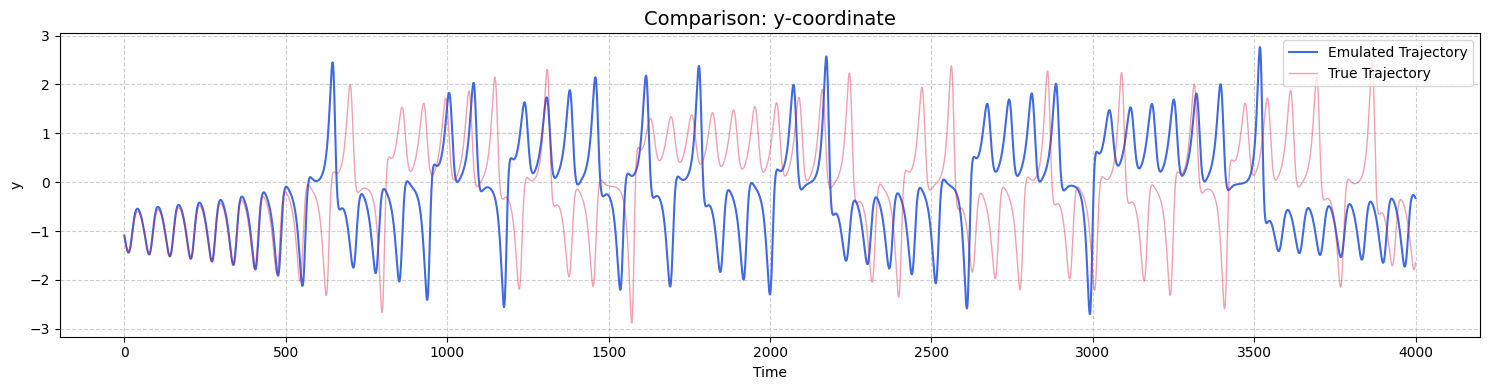

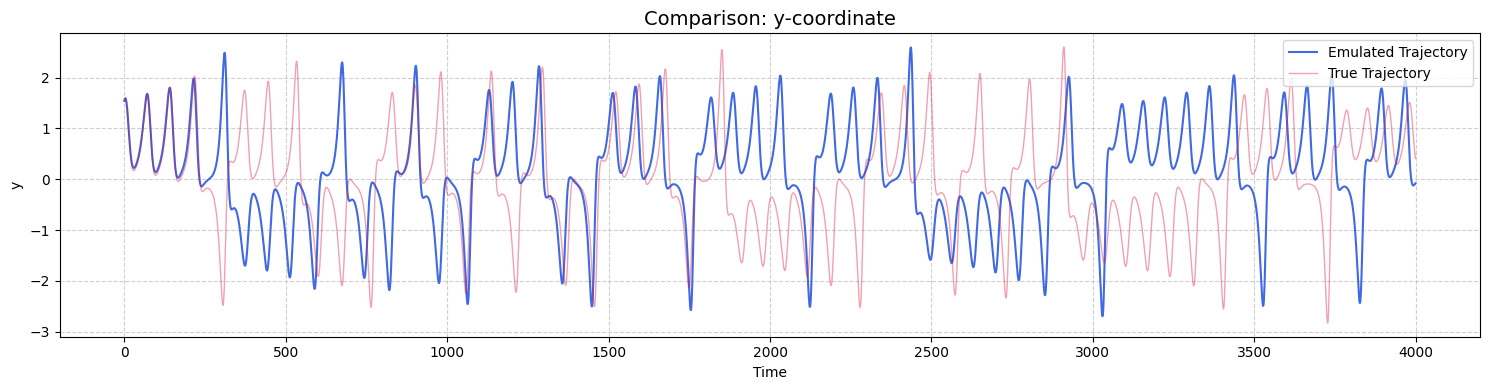

(None, None, None)

In [83]:
# 3 different initial conditions for y axis
plot_coordinate_comparison(1, emulated_traj[0], testing_set[0]), plot_coordinate_comparison(1, emulated_traj[1], testing_set[1]), plot_coordinate_comparison(1, emulated_traj[2], testing_set[2])

The emulator is not very accurate it seems for the x axis or y axis, at least visually. But, the MSE seems pretty low after normalization. A notable characteristic is that the emulator is not good at replicating the 'rapid change' in size (from + to -) seen in the original trajectory.  

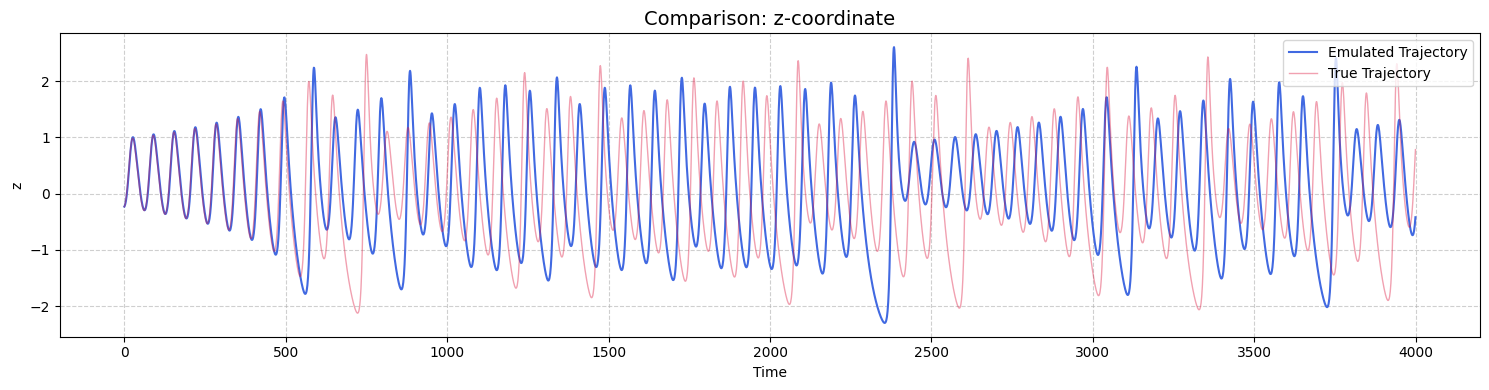

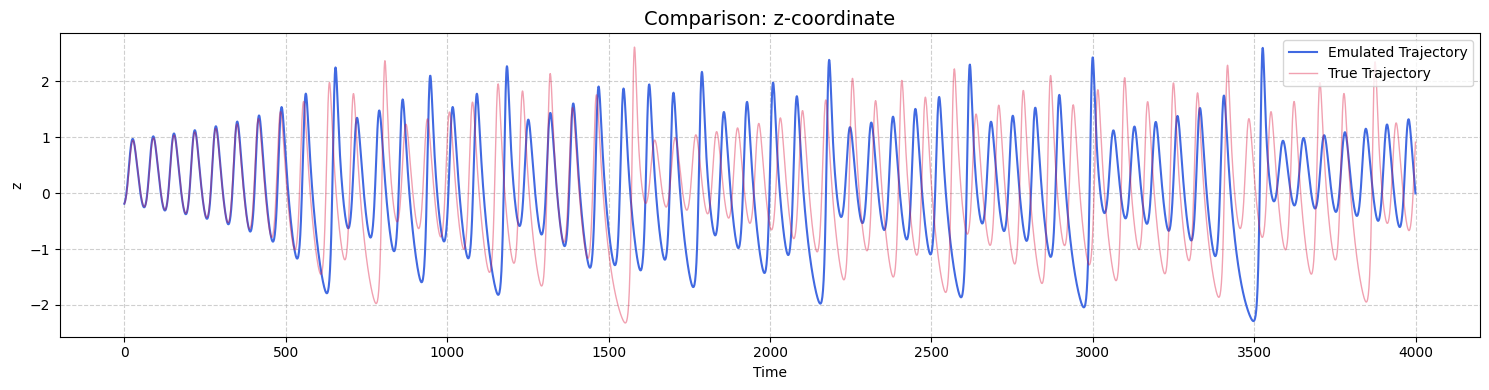

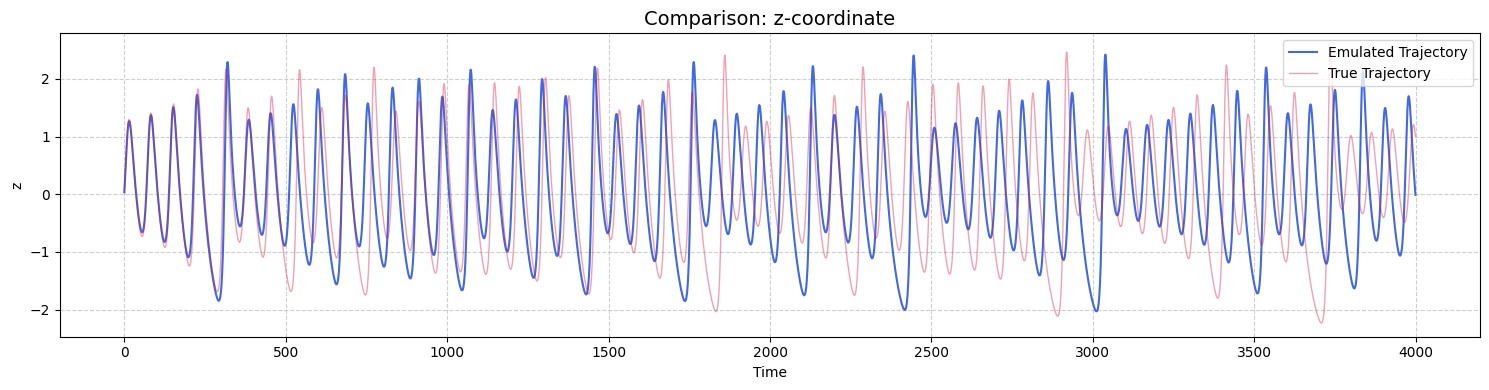

(None, None, None)

In [84]:
# 3 different initial conditions for z axis
plot_coordinate_comparison(2, emulated_traj[0], testing_set[0]), plot_coordinate_comparison(2, emulated_traj[1], testing_set[1]), plot_coordinate_comparison(2, emulated_traj[2], testing_set[2])

Looks quite accurate for the z axis, perhaps because of the lack of variations. I am not surprised because the NN architecture is quite unsophisticated. Let's look at the test MSE.

In [85]:
# testing MSE
def MSE(true, emulated):
    return jnp.mean(jnp.square(true - emulated), axis = 0)

MSE(testing_set[3], emulated_traj[3])

Array([2.0355544, 2.0398018, 1.4520937], dtype=float32)

I am interested in pursuing two different directions:

    - Trying a different architecture like ResNet or NeuralODE
    - Introducing error into the data either by simple deviation or by correlated terms.

We will follow a process commonly seen in control systems. Usually there is an underlying process that generates observations. In our case, the observations are generated by the `LorenzSimulatorK4`. Assume that the dynamics of the system is baked into the function $f(u)$ where $u$ is the state vector. We have seen this already: $u = [x,y,z]^T$ and $\dot{u} = [\dot{x},\dot{y},\dot{z}]^T$. The system advances in the following manner:
$$ u_{T+1} = \mathcal{F}(u_T) $$ where $\mathcal{F}$ is the 4-th order runge-kutta based simulator.  We'll experiment with the dynamics by introducing 'sensor' noise into the observable trajectory $$h(u_T) = \mathcal{F}(u_T) + w_u$$ where $w_u = \mathcal{N}(0,\sigma_u)$ and $\sigma_u = \text{diag}[\sigma^x, \sigma^y, \sigma^z]$. Note the unique advantage we assume in this situation: we know the exact equations that govern the dynamics of the system, unlike UAV trajectory where we leave room for process error caused by our imperfect modelling of the system. 

Looks pretty much the same.